In [23]:
# open the generated synthetic data file and read it as a python dictionary called data

import json

file = open('synthetic_dataset_with_time.txt', 'r')
text = file.read()
data = json.loads(text)


In [33]:
import emip_toolkit as EMTK

# find areas of interest (AOIs) once again
image_path = "./"
image = "synthetic_text.png"
aoi = EMTK.find_aoi(image, image_path, level="sub-line")


# add tokens to AOIs 
file_path = "./"
aois_with_tokens = EMTK.add_tokens_to_AOIs(file_path, image.split(".")[0]+".txt", aoi)
aois_with_tokens.head()


import correction

# find the y coordinate of each line in the text
line_ys = correction.find_lines_Y(aoi)

In [34]:
import numpy as np
import drift_algorithms_osf as algo
from tqdm import tqdm

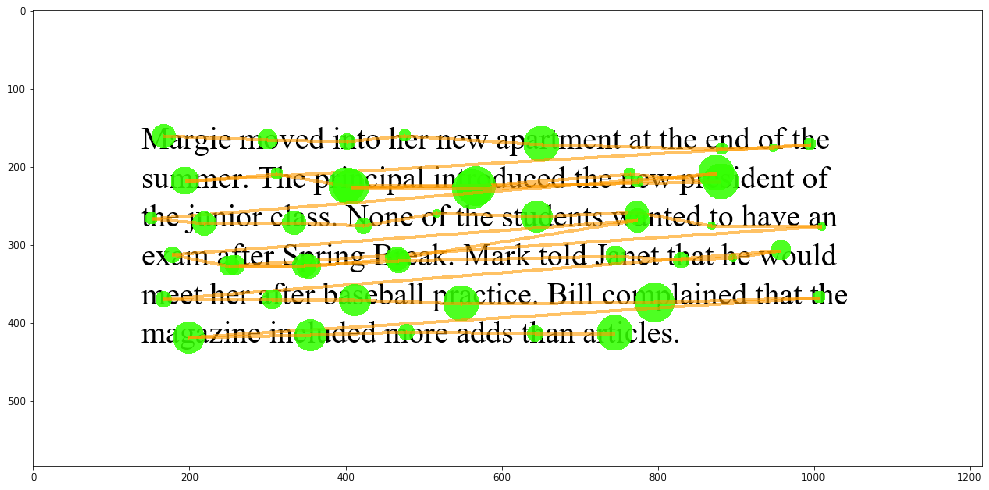

In [35]:
# draw original correct fixations

correction.draw_fixation('synthetic_text.png', data['robot1'].copy())

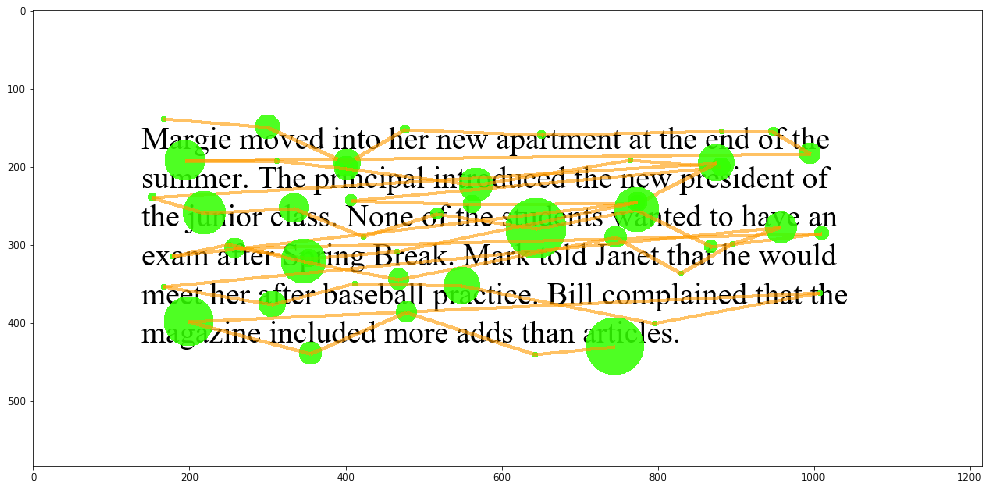

In [36]:
# generate noise over the correct trial

error_test = correction.error_noise(1, 30, 1, data['robot1'].copy())

# draw the trial with added error
correction.draw_fixation('synthetic_text.png', error_test)

0.98


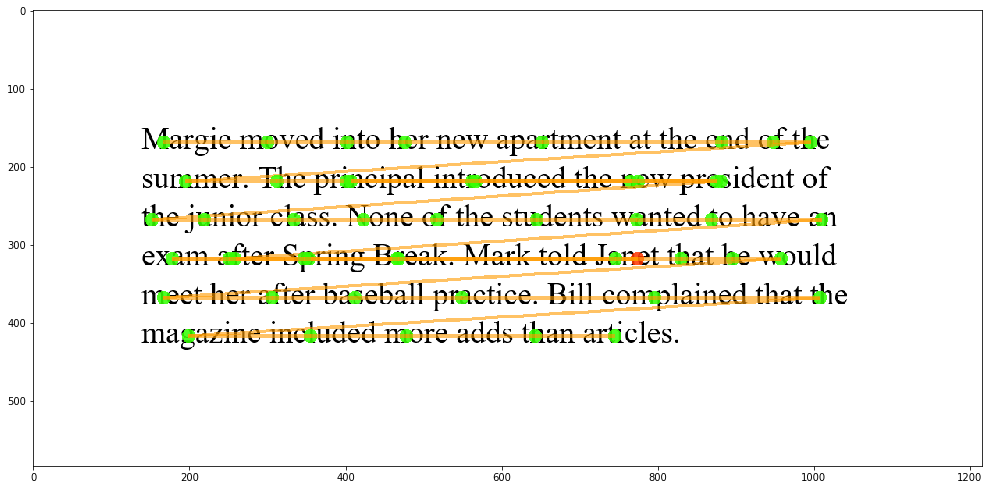

In [37]:
# find the center of each word, we need this for warp algorithm
word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

# warp correction
np_array = np.array(error_test.copy(), dtype=int)
durations = np.delete(np_array, 0, 1)
durations = np.delete(durations, 0, 1)
np_array = np.delete(np_array, 2, 1)

# run warp
warp_correction = algo.warp(np_array, word_centers)

# this is a cool function that checks the quality of the correction
percentage, match_list = correction.correction_quality(aoi, data['robot1'].copy(), warp_correction)
print(percentage)

# this is a cool function that draws the correction in red if the algorithm made a mistake
correction.draw_correction('synthetic_text.png', warp_correction, match_list)

This concludes the example I wanted to show you of running an error generator, then correcting the data, then seeing how well the correction algorithm did.  You will need to repeat the same concept for a bunch of algorithms in the next section.

# Comparing algorithms with Noise error:

In this example, I show you one type of erro "Noise" you will implement all 5 types and add skipping to your assessment.  Also, the code below runs only 4 algorithms, you will add the remaining 6 algorithms to this assessment for each type of error. 

In [81]:
algorithms = ["attach", "chain", "cluster", "compare", "merge", "regress", "segment", "split", "stretch", "warp"]
results = {alg:[[],[],[],[],[],[],[],[],[],[],[]] for alg in algorithms}
results

{'attach': [[], [], [], [], [], [], [], [], [], [], []],
 'chain': [[], [], [], [], [], [], [], [], [], [], []],
 'cluster': [[], [], [], [], [], [], [], [], [], [], []],
 'compare': [[], [], [], [], [], [], [], [], [], [], []],
 'merge': [[], [], [], [], [], [], [], [], [], [], []],
 'regress': [[], [], [], [], [], [], [], [], [], [], []],
 'segment': [[], [], [], [], [], [], [], [], [], [], []],
 'split': [[], [], [], [], [], [], [], [], [], [], []],
 'stretch': [[], [], [], [], [], [], [], [], [], [], []],
 'warp': [[], [], [], [], [], [], [], [], [], [], []]}

In [82]:
word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

In [83]:
duration_word_centers = correction.find_word_centers_and_duration(aois_with_tokens)
duration_word_centers = np.array(duration_word_centers.copy(), dtype=int)

In [93]:
%%timeit -r 1 -n 1

word_center_algo = ["compare", "warp"]

for robot_index in tqdm(range(2)):
    print("starting robot_index", robot_index)
    for error_probability in range(0, 11):
        
        # generate error
        error_test = correction.error_noise(error_probability/10, 30, error_probability/10, data['robot' + str(robot_index)].copy())

        for alg in algorithms:
            
            error_test_copy = np.array(error_test.copy())
            if alg in word_center_algo:
                model_guess = getattr(algo, alg)(error_test_copy[:,:2], word_centers)
            else:
                model_guess = getattr(algo, alg)(error_test_copy, np.array(line_ys))
            
            percentage, match_list = correction.correction_quality(aoi, data['robot' + str(robot_index)].copy(), model_guess)
            results[alg][error_probability].append(percentage)
            
    
        # warp correction
        #np_array = np.array(error_test.copy(), dtype=int)
        #durations = np.delete(np_array, 0, 1)
        #durations = np.delete(durations, 0, 1)
        #np_array = np.delete(np_array, 2, 1)
        
        #warp_correction = algo.warp(np_array, word_centers)
        #percentage, match_list = correction.correction_quality(aoi, data['robot' + str(robot_index)].copy(), warp_correction)

        if percentage < 1:
            #correction.draw_correction('synthetic_text.png', warp_correction, match_list)
            print("robot:", robot_index, "    error probability:", error_probability)


  0%|          | 0/2 [00:00<?, ?it/s]

starting robot_index 0
robot: 0     error probability: 0
robot: 0     error probability: 1
robot: 0     error probability: 2
robot: 0     error probability: 3
robot: 0     error probability: 4
robot: 0     error probability: 5
robot: 0     error probability: 6
robot: 0     error probability: 7
robot: 0     error probability: 8
robot: 0     error probability: 9


 50%|█████     | 1/2 [00:33<00:33, 33.19s/it]

robot: 0     error probability: 10
starting robot_index 1
robot: 1     error probability: 0
robot: 1     error probability: 1
robot: 1     error probability: 2
robot: 1     error probability: 3
robot: 1     error probability: 4
robot: 1     error probability: 5
robot: 1     error probability: 6
robot: 1     error probability: 7
robot: 1     error probability: 8
robot: 1     error probability: 9


100%|██████████| 2/2 [00:57<00:00, 28.94s/it]

robot: 1     error probability: 10
57.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [85]:
import statistics

def mean_error_group(results):
    new_list = []
    
    for result in results:
        new_list.append(statistics.mean(result))
        
    return new_list

In [86]:
mean_results = {alg:mean_error_group(results[alg]) for alg in algorithms}

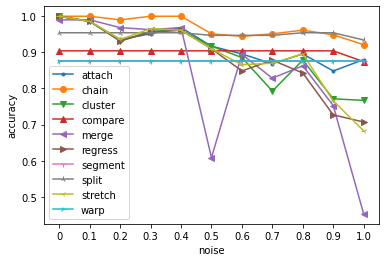

In [88]:
import matplotlib.pyplot as plt
markers = ".ov^<>1234"
for i, alg in enumerate(algorithms):
    plt.plot(mean_results[alg], marker=markers[i]) # color='Black', linewidth=1, marker='^')

plt.legend(algorithms)
plt.ylabel('accuracy')
plt.xlabel('noise')

x_ticks_labels = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
plt.xticks(range(0, 11), x_ticks_labels)
#plt.savefig("noise_comparison.png")
plt.show()

In [90]:
for alg in algorithms:
    print(f"mean {alg}:", statistics.mean(mean_results[alg]))

mean attach: 0.9224675324675324
mean chain: 0.9698701298701299
mean cluster: 0.8954545454545455
mean compare: 0.9015584415584417
mean merge: 0.8436363636363636
mean regress: 0.8862337662337663
mean segment: 0.8757142857142857
mean split: 0.9505194805194805
mean stretch: 0.8944155844155844
mean warp: 0.8757142857142857
